<div style="text-align: center;">
    <img src="https://img.freepik.com/free-vector/businessman-pushing-credit-score-speedometer-from-poor-good-tiny-person-improving-personal-credit-history-with-efforts-flat-vector-illustration-business-reputation-customer-loan-concept_74855-20943.jpg?w=740&t=st=1696525462~exp=1696526062~hmac=12cdc5dcb2b9e55f2cf928026560fbb7cbe4bb135e92e23b136bc99b026fa1ab" alt="Fraud Transaction" width="500"/>
    <p style="text-align: center;"><a href="https://www.freepik.com/free-vector/hacker-activity-concept_7970717.htm#query=fraud%20transaction&position=3&from_view=search&track=ais">Image by freepik</a><p>
</div>

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE')

if iskaggle:
    path = '/kaggle/input/german-credit-data-with-risk'
else:
    path = "{}".format(os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
color_dict = {'good': 'limegreen', 'bad': 'salmon'}

In [3]:
data = pd.read_csv(os.path.join(path,'german_credit_data.csv'), index_col=0)

In [4]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [6]:
# Convert 'Job' column dtype from 'int64' to 'category'
data.Job = data.Job.astype('category')

# Identify categorical columns based on data type
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
data[categorical_columns] = data[categorical_columns].astype('category')
print('Unique values for every categorical columns in dataset\n')
    
# Loop through each categorical column and print unique values
for column in categorical_columns:
    print(f"\t{column}: {list(data[column].unique())}\n")


Unique values for every categorical columns in dataset

	Sex: ['male', 'female']

	Job: [2, 1, 3, 0]

	Housing: ['own', 'free', 'rent']

	Saving accounts: [nan, 'little', 'quite rich', 'rich', 'moderate']

	Checking account: ['little', 'moderate', nan, 'rich']

	Purpose: ['radio/TV', 'education', 'furniture/equipment', 'car', 'business', 'domestic appliances', 'repairs', 'vacation/others']

	Risk: ['good', 'bad']



In [7]:
data.describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


In [8]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

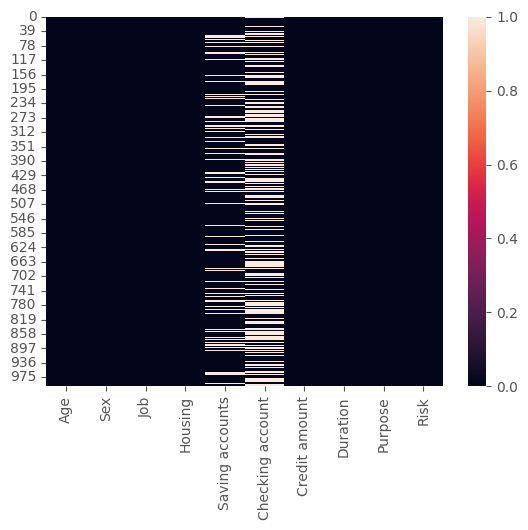

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [9]:
sns.heatmap(data.isna())
plt.show()
print(data.isna().sum())

In [10]:
data.duplicated().sum()

0

# Data Cleaning

In [11]:
df_cleaned = data.copy()

In [12]:
# Data Imputing
for column in categorical_columns:
    most_frequent = df_cleaned[column].mode()[0]  # Get the most frequent value for each column
    df_cleaned[column].fillna(most_frequent, inplace=True)  # Fill NaN values with the most frequent value

In [13]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1000 non-null   int64   
 1   Sex               1000 non-null   category
 2   Job               1000 non-null   category
 3   Housing           1000 non-null   category
 4   Saving accounts   1000 non-null   category
 5   Checking account  1000 non-null   category
 6   Credit amount     1000 non-null   int64   
 7   Duration          1000 non-null   int64   
 8   Purpose           1000 non-null   category
 9   Risk              1000 non-null   category
dtypes: category(7), int64(3)
memory usage: 39.3 KB


In [14]:
# Remove Outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1-1.5*IQR
    upper = Q3+1.5*IQR
    
    return df.loc[(df[column] >= lower) & (df[column] <= upper)]

numerical_columns = df_cleaned.select_dtypes('int64').columns

# Apply to 'numerical' columns
for col in numerical_columns:
    df_cleaned = remove_outliers(df_cleaned, col)

In [15]:
df_cleaned.describe()

,Age,Credit amount,Duration
count,861.000000,861.000000,861.000000
mean,34.686411,2525.218351,18.088269
std,10.264713,1654.553716,8.656849
min,19.000000,250.000000,4.000000
25%,27.000000,1308.000000,12.000000
50%,33.000000,2064.000000,18.000000
75%,41.000000,3349.000000,24.000000
max,64.000000,7865.000000,42.000000


# Data Visaulizing

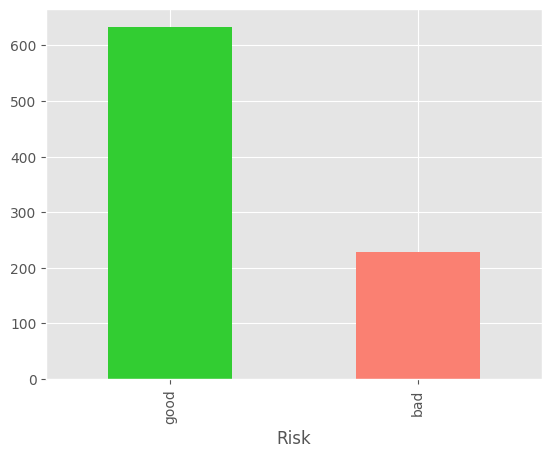

In [16]:
ordered_colors = [color_dict[label] for label in df_cleaned['Risk'].value_counts().index]
df_cleaned['Risk'].value_counts().plot(kind='bar', color=ordered_colors)
plt.show()

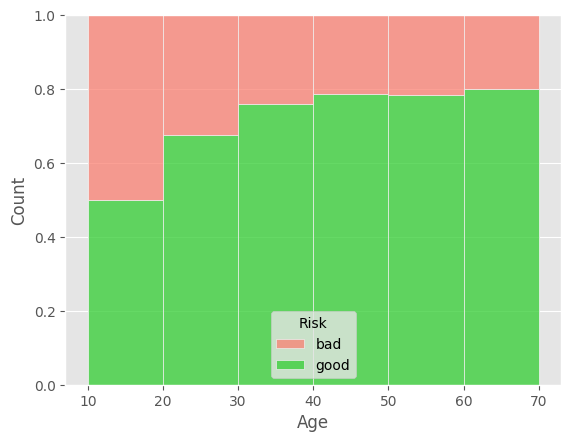

In [17]:
sns.histplot(data=df_cleaned, x='Age', hue='Risk', binrange=[0,80], binwidth=10, palette=color_dict, multiple='fill')
plt.show()

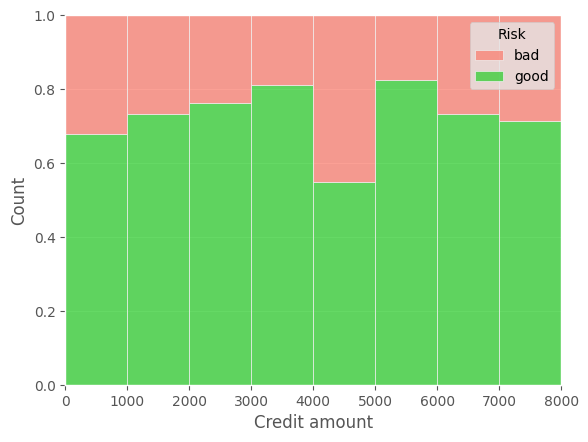

In [18]:
sns.histplot(data=df_cleaned, x='Credit amount', hue='Risk', binrange=[0,8000], binwidth=1000,palette=color_dict, multiple='fill')
plt.show()

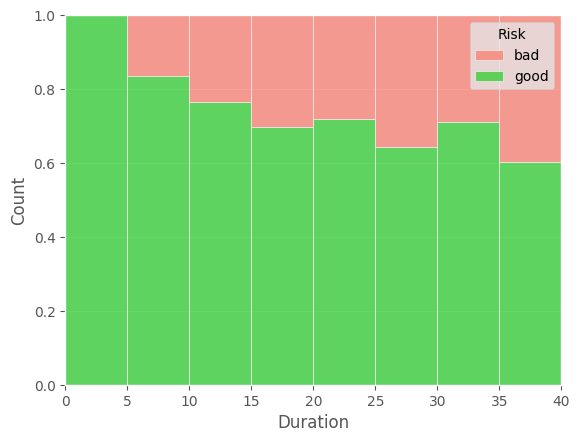

In [19]:
sns.histplot(data=df_cleaned, x='Duration', hue='Risk', binrange=[0,40], binwidth=5,palette=color_dict, multiple='fill')
plt.show()

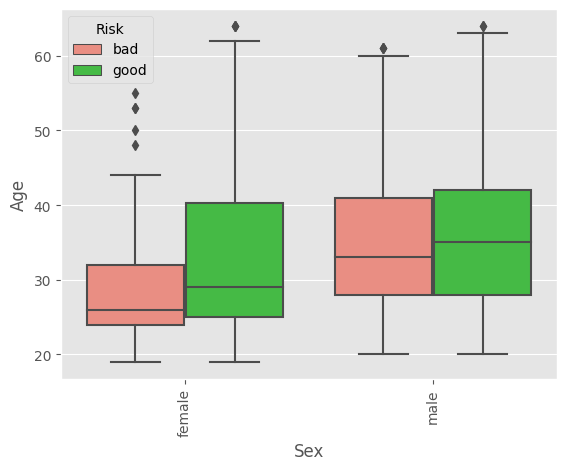

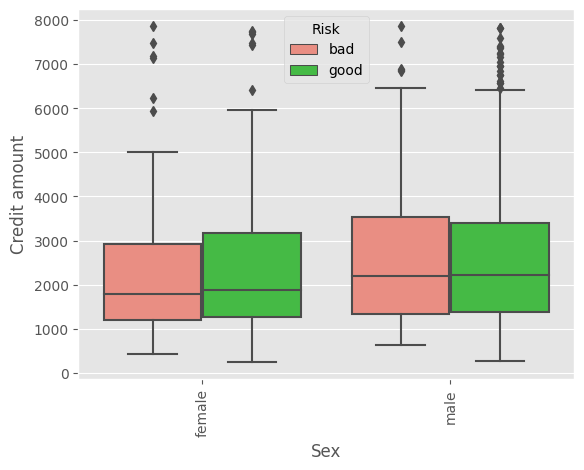

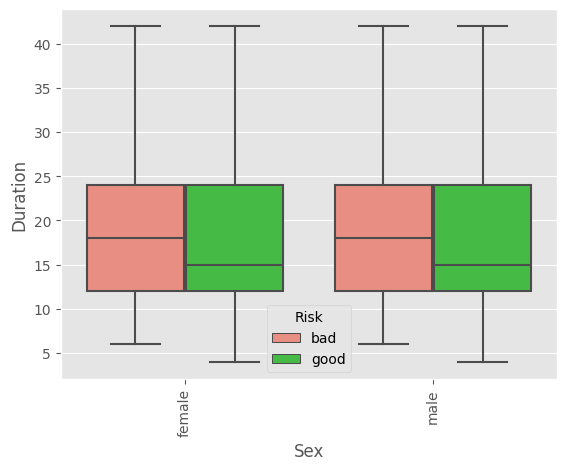

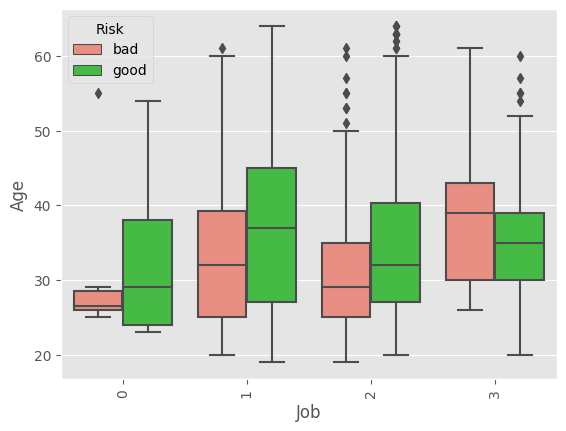

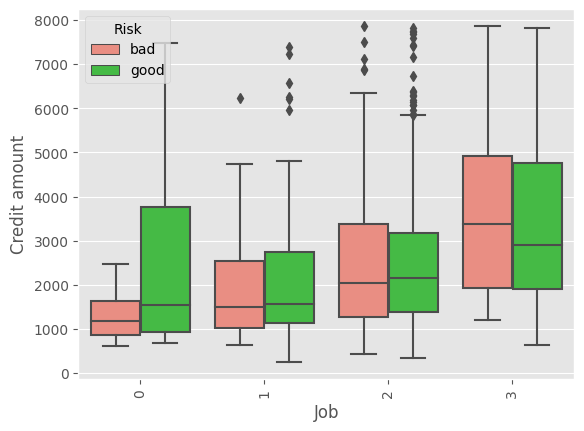

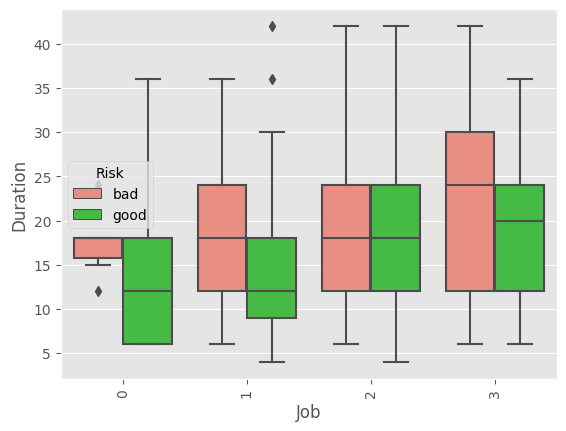

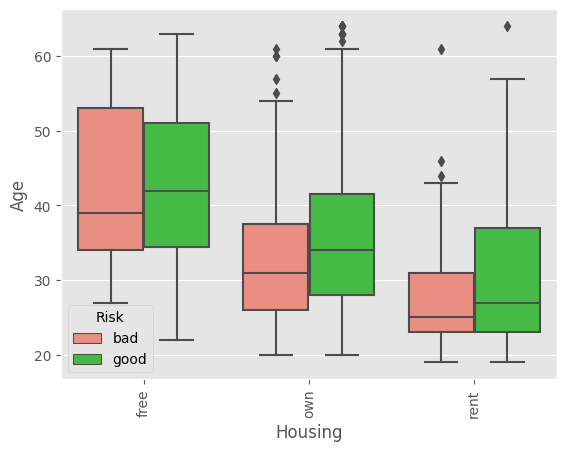

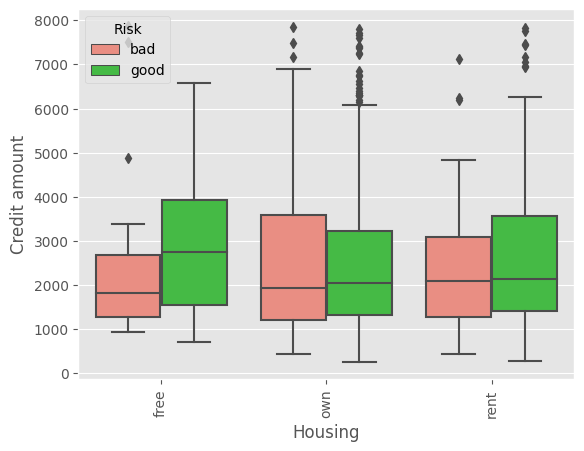

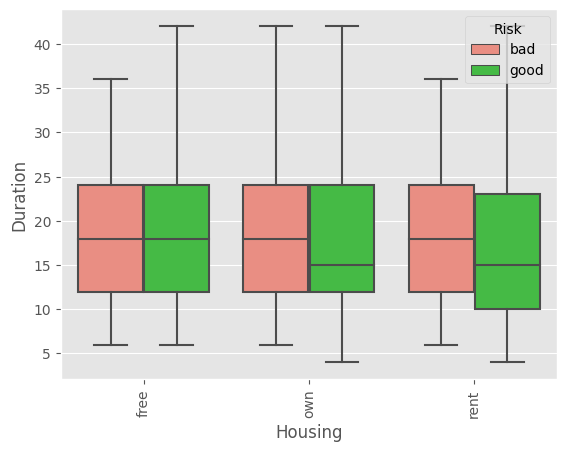

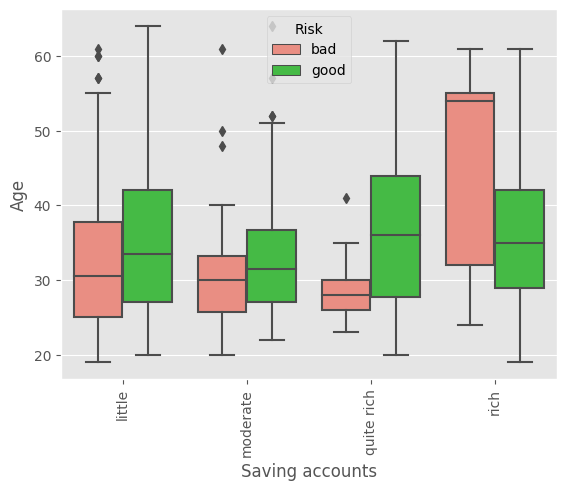

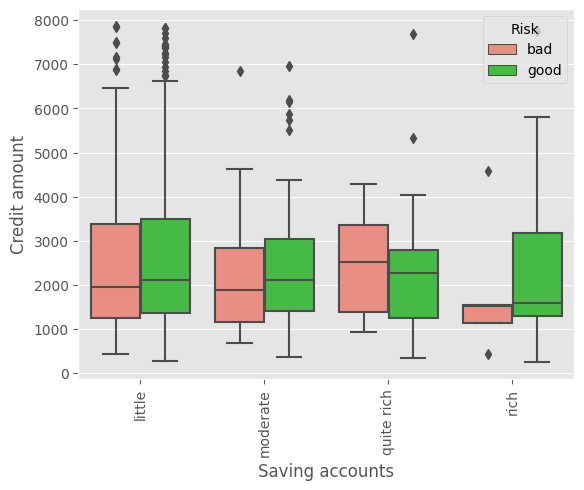

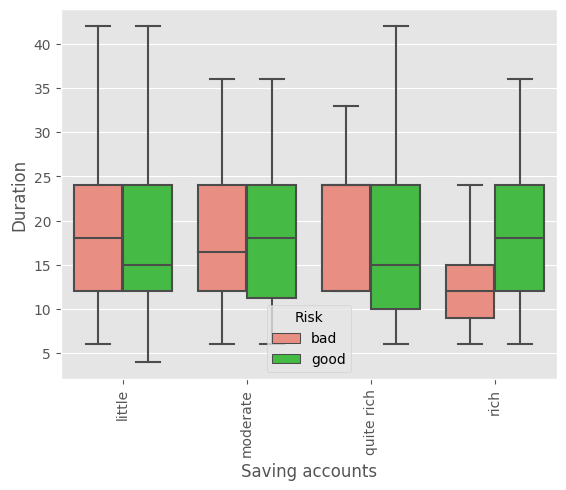

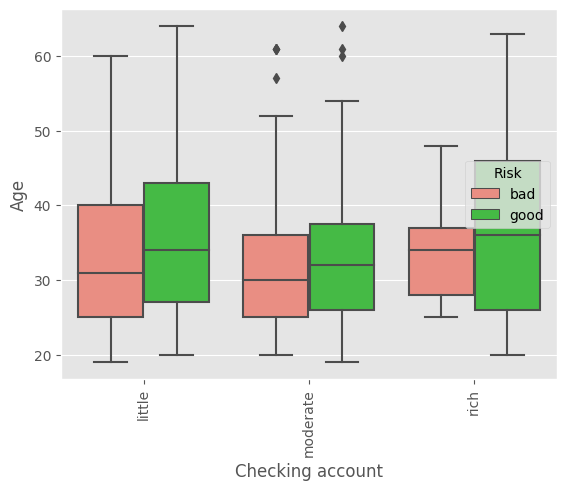

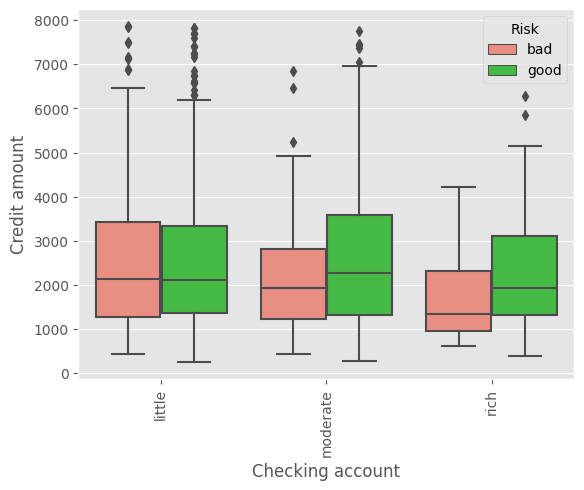

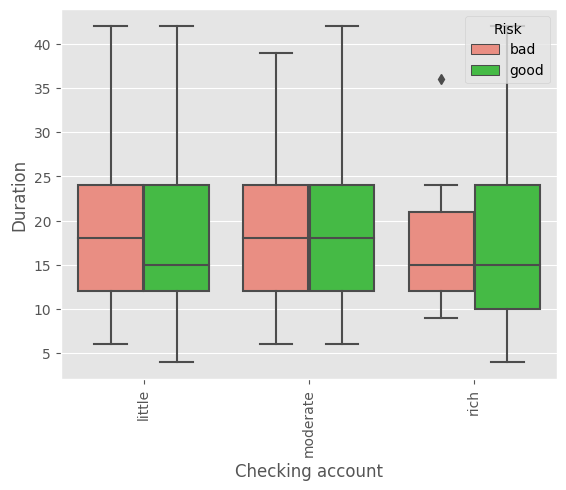

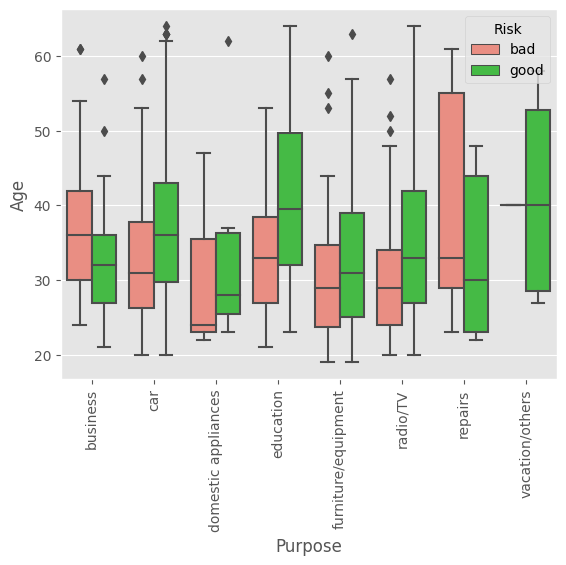

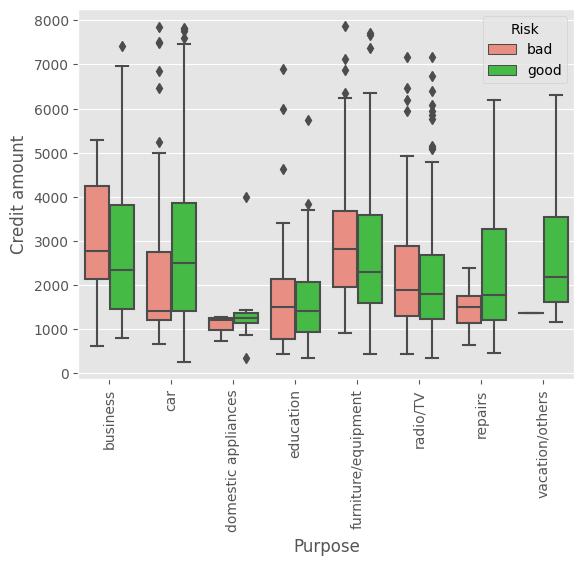

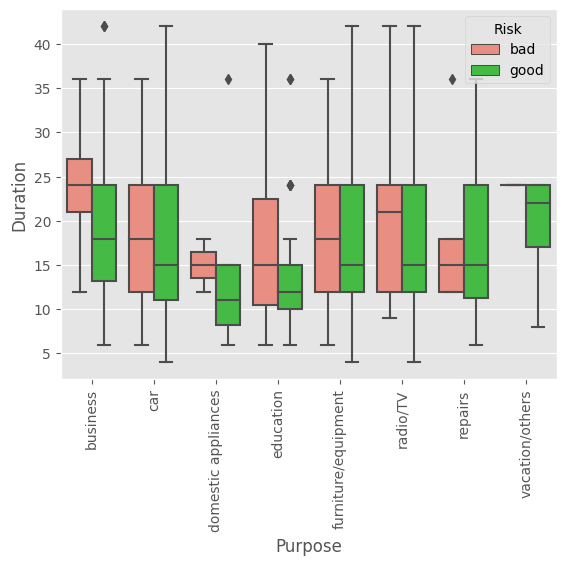

In [20]:
# Boxplot 'numrical' variables across all 'categorical' vaiables
def create_plot0(df, categorical_cols, numerical_cols ,hue):
    for cat in categorical_cols:
        df = df.sort_values(cat)
        for num in numerical_cols:
            sns.boxplot(x=cat, y=num, hue=hue, data=df, palette=color_dict)
            plt.tight_layout
            plt.xticks(rotation=90)
            plt.show()
            print("\n\n")
            
create_plot0(df_cleaned, categorical_columns.drop('Risk'), numerical_columns, 'Risk')


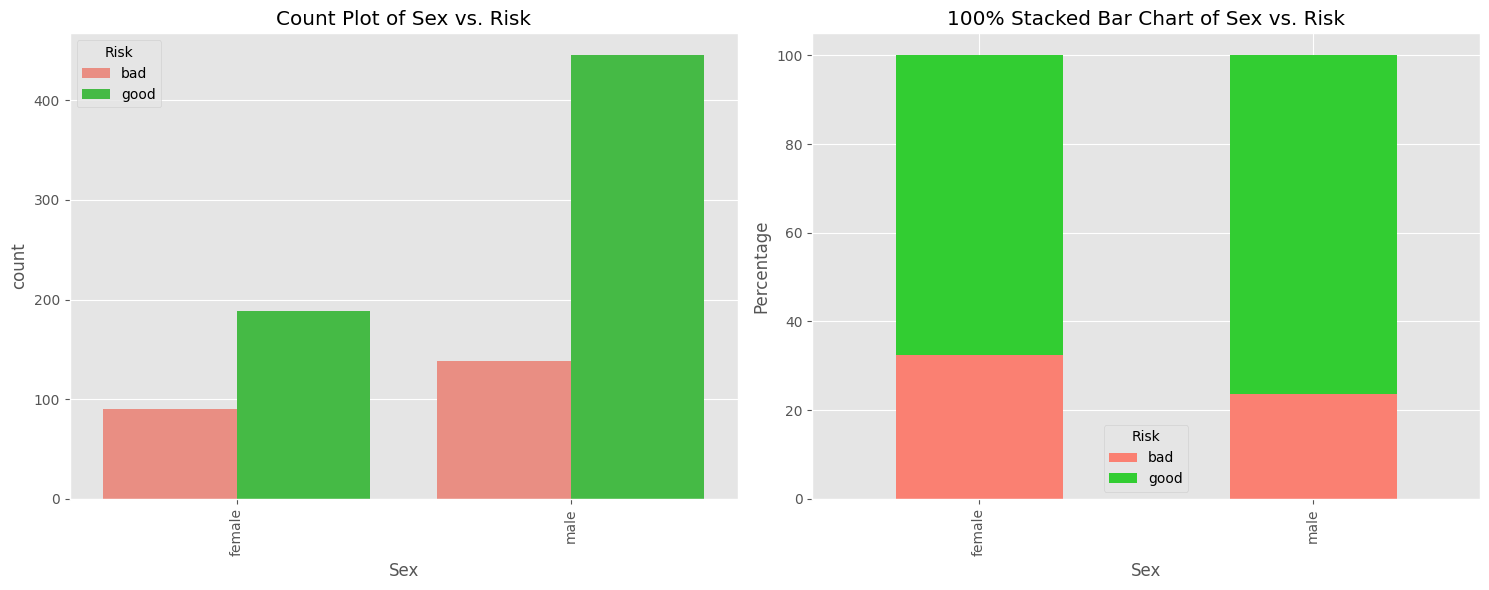

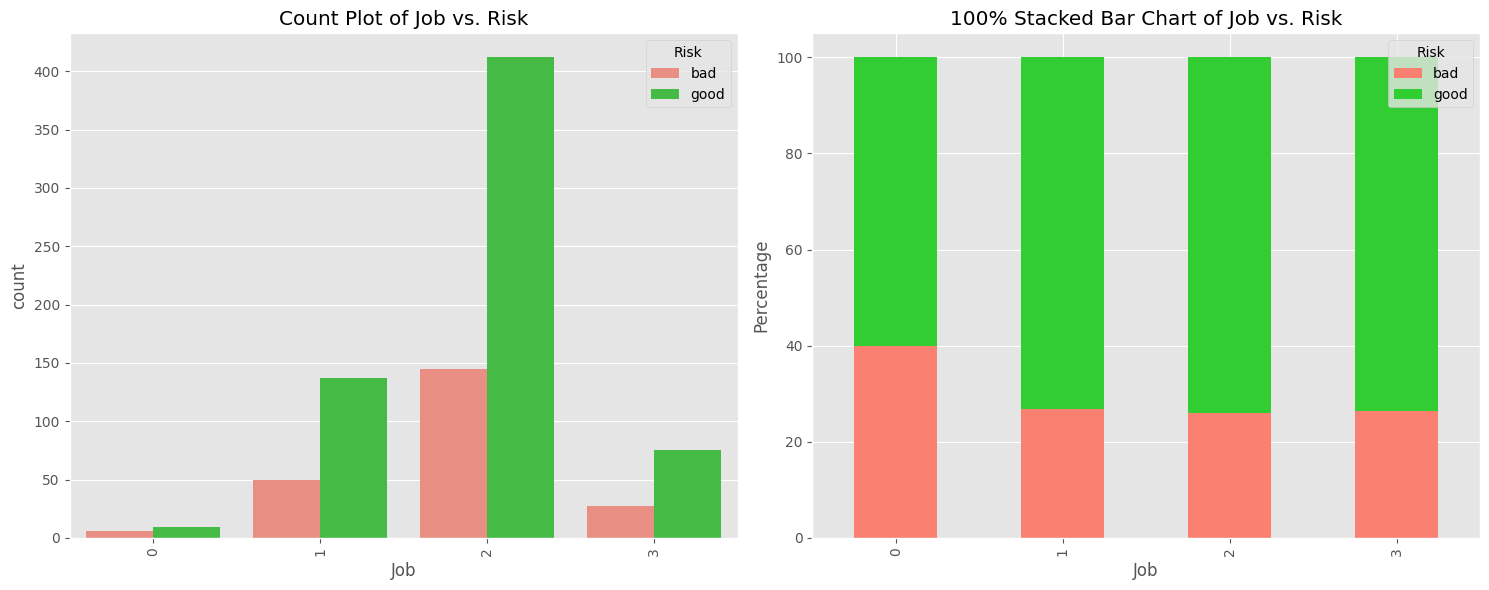

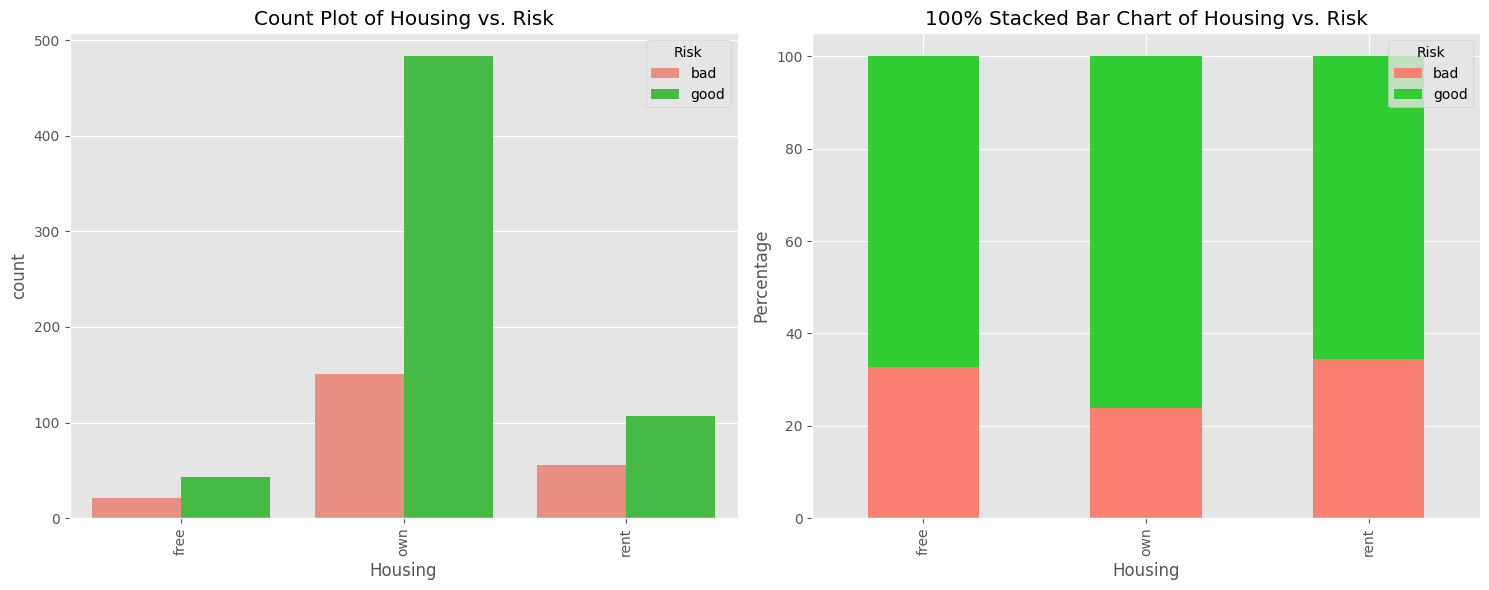

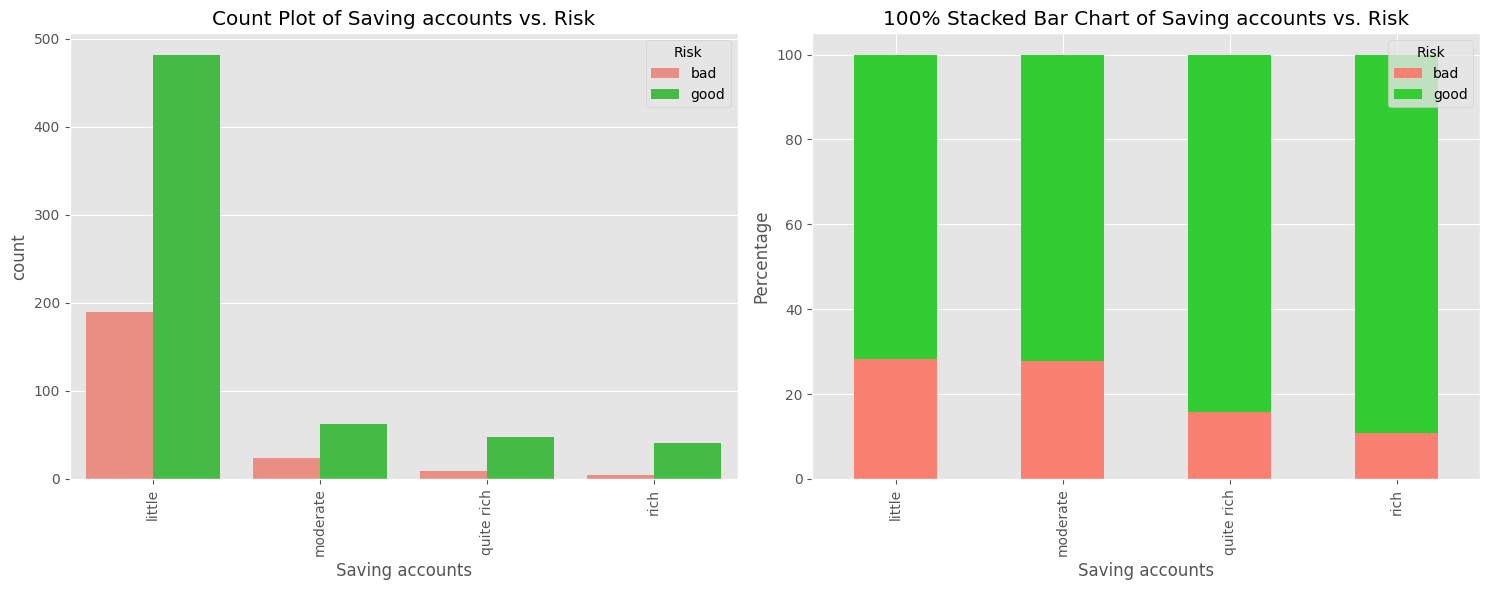

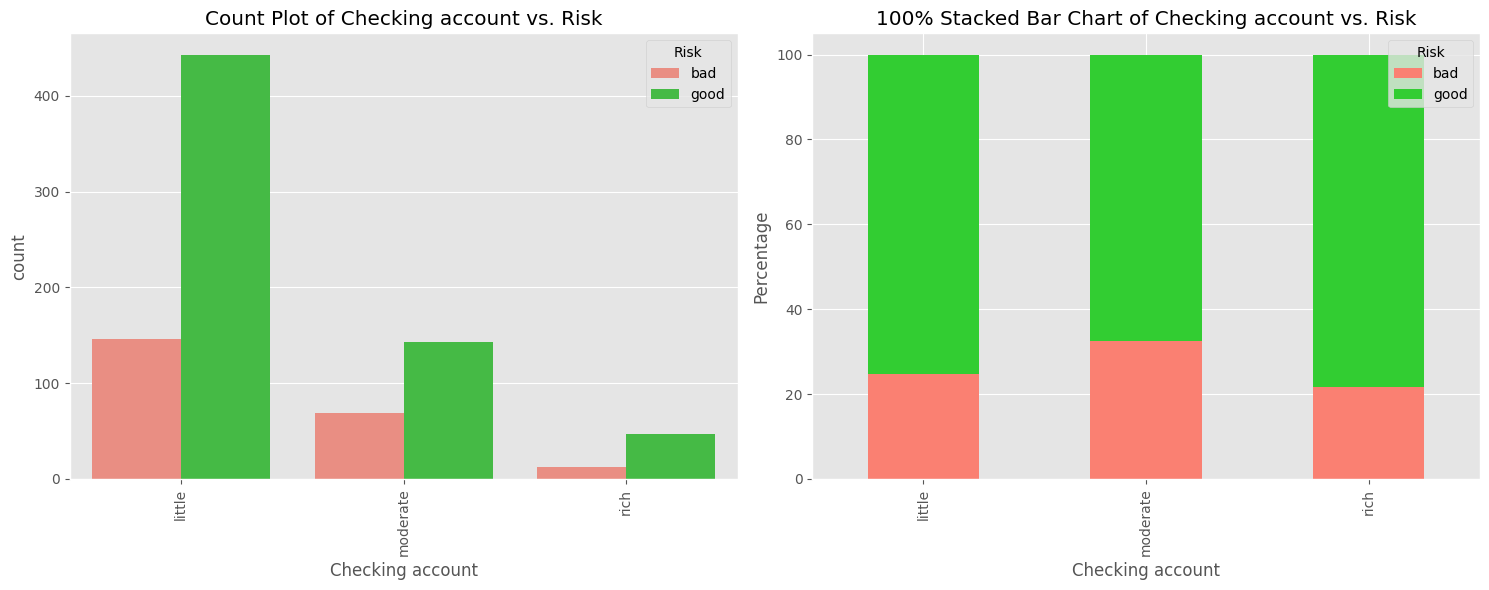

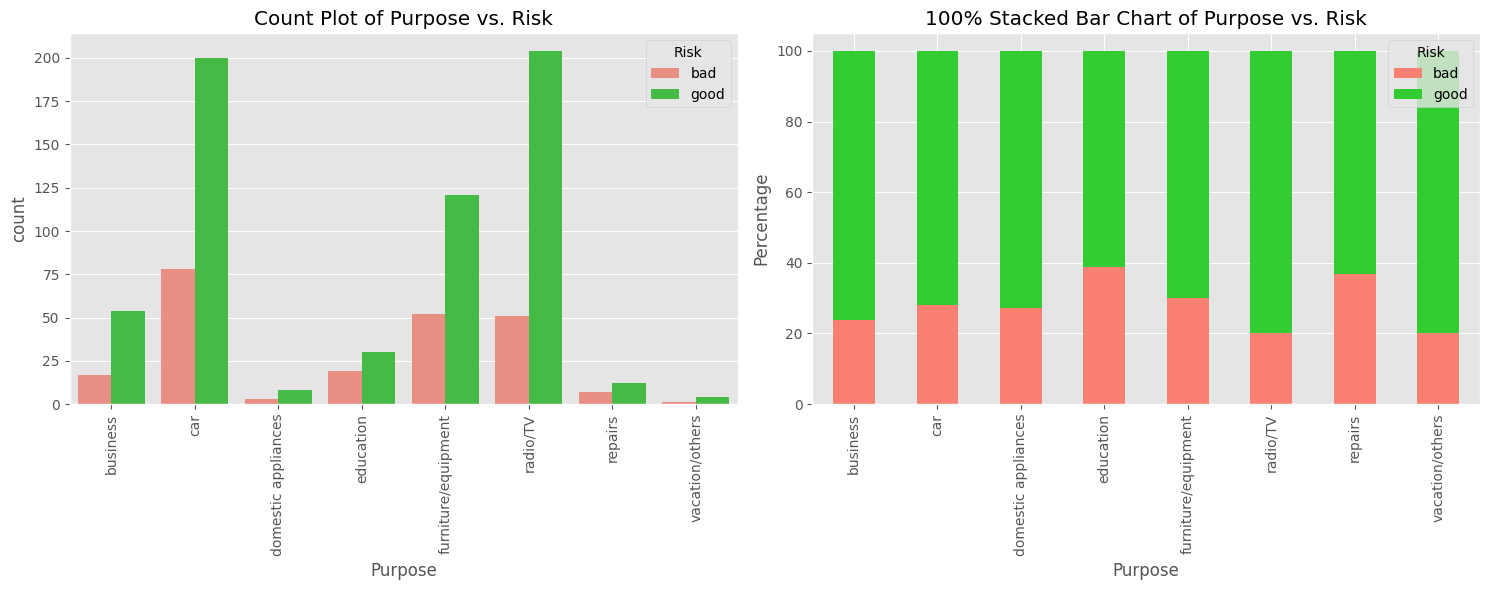

In [21]:
# Plots Categories Columns
def create_plots_1(df, cat_feature, hue_feature):
    
    df = df.sort_values(cat_feature)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    
    # Plot for count plot
    sns.countplot(x=cat_feature, hue=hue_feature, data=df, ax=axes[0], palette=color_dict)
    axes[0].set_title(f'Count Plot of {cat_feature} vs. {hue_feature}')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

    # Plot for 100% stacked bar chart
    ct = pd.crosstab(df[cat_feature], df[hue_feature])
    ct_percentage = ct.div(ct.sum(axis=1), axis=0) * 100
    ct_percentage.plot(kind='bar', stacked=True, ax=axes[1], color=[color_dict[hue] for hue in ct.columns])
    axes[1].set_ylabel('Percentage')
    axes[1].set_title(f'100% Stacked Bar Chart of {cat_feature} vs. {hue_feature}')

    plt.tight_layout()
    plt.show()


for col in categorical_columns.drop('Risk'):
    create_plots_1(df_cleaned, col, 'Risk')


# Data Preprocessing

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(columns=['Risk'])
y = df_cleaned['Risk']
X_transformed = X.copy()

In [23]:
# Features Viriables Scaling
scaler = MinMaxScaler()
scaler.fit(X_transformed[numerical_columns])
X_transformed[numerical_columns] = scaler.transform(X_transformed[numerical_columns])

In [24]:
X_transformed.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
2,0.666667,male,1,own,little,little,0.242416,0.210526,education
4,0.755556,male,2,free,little,little,0.606697,0.526316,car
6,0.755556,male,2,own,quite rich,little,0.339462,0.526316,furniture/equipment
7,0.355556,male,3,rent,little,moderate,0.879580,0.842105,car
8,0.933333,male,1,own,rich,little,0.368877,0.210526,radio/TV


In [25]:
# OneHotEncoder
for col in [item for item in categorical_columns if item not in ['Risk']]:
    dummies = pd.get_dummies(X_transformed[col], prefix=col)
    X_transformed.drop(col, axis=1, inplace=True)
    X_transformed = pd.concat([X_transformed, dummies], axis=1)

In [26]:
X_transformed.head()

,Age,Credit amount,Duration,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
2,0.666667,0.242416,0.210526,False,True,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,0.755556,0.606697,0.526316,False,True,False,False,True,False,True,...,False,False,False,True,False,False,False,False,False,False
6,0.755556,0.339462,0.526316,False,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
7,0.355556,0.879580,0.842105,False,True,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
8,0.933333,0.368877,0.210526,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [27]:
# Apply SMOTE
from imblearn.over_sampling import SMOTE

def smote(X, y, sampling_strategy='minority'):
    
    # Original label
    print('Before')
    print(f'{y.value_counts()}')
    
    # Initialize SMOTE
    smote = SMOTE(sampling_strategy='minority', random_state=21)

    # Apply SMOTE to our data and check the counts
    X_smote, y_smote = smote.fit_resample(X, y)

    # Convert the result back to a dataframe
    X_smote_df = pd.DataFrame(X_smote, columns=X.columns)
    
    # Transformed label
    print('\n\nAfter SMOTE')
    print(f'{y_smote.value_counts()}')

    return X_smote_df, y_smote

X_transformed, y = smote(X_transformed,y)



Before
Risk
good    633
bad     228
Name: count, dtype: int64


After SMOTE
Risk
bad     633
good    633
Name: count, dtype: int64


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=21)

# Model Training and Evaluating

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support

import time

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

In [30]:
from sklearn.model_selection import StratifiedKFold, cross_validate


# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Gaussian NB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)  # Set verbose=0 to not print training progress
}

# Initialize the StratifiedKFold object
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# Define the scoring metrics we want to compute
scoring = ['roc_auc']

for model_name, model in models.items():
    # Use cross_validate to get the scores for each fold
    scores = cross_validate(model, X_transformed, y, cv=kfold, scoring=scoring)

    # Print the mean and std for each metric
    for metric_name, score_values in scores.items():
        if metric_name not in ['fit_time', 'score_time']:
            print(f"{model_name} {metric_name}: {np.mean(score_values):.2f} ± {np.std(score_values):.2f}")


Logistic Regression test_roc_auc: 0.81 ± 0.03
Gaussian NB test_roc_auc: 0.67 ± 0.04
Decision Tree test_roc_auc: 0.69 ± 0.01
Random Forest test_roc_auc: 0.88 ± 0.02
AdaBoost test_roc_auc: 0.76 ± 0.03
Gradient Boosting test_roc_auc: 0.83 ± 0.02
CatBoost test_roc_auc: 0.87 ± 0.01


In [31]:
def run_model_and_evaluate(model, X_train, X_test, y_train, y_test):
    
    start_time = time.time()  # Start the timer

    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate elapsed time in seconds

    # Evaluate classifier's performance
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilities to compute ROC AUC
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
    
    metrics_dict = {
        'running_time': elapsed_time,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    print(f"Running Time: {elapsed_time:.2f} seconds")
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC: {roc_auc}")
    print(classification_report(y_test, y_pred))

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test.map({'bad':0, 'good':1}), y_pred_proba)    

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=["bad", "good"], yticklabels=["bad", "good"], ax=axes[0])
    axes[0].set_xlabel('Predicted labels')
    axes[0].set_ylabel('True labels')
    axes[0].set_title('Confusion Matrix')

    # ROC curve
    axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[1].legend(loc='lower right')
    axes[1].grid(alpha=0.2)

    plt.tight_layout()
    plt.show()
    
    return metrics_dict

Running Time: 0.05 seconds
Accuracy: 0.7401574803149606
ROC AUC: 0.7993537562915554
              precision    recall  f1-score   support

         bad       0.77      0.65      0.71       121
        good       0.72      0.82      0.77       133

    accuracy                           0.74       254
   macro avg       0.74      0.74      0.74       254
weighted avg       0.74      0.74      0.74       254



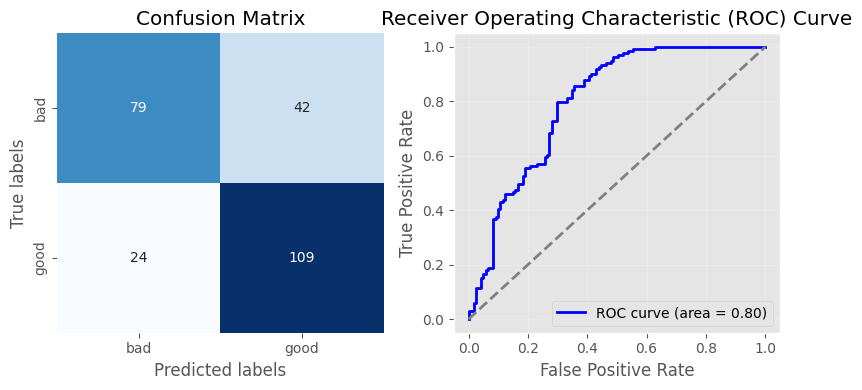

In [32]:
lr = run_model_and_evaluate(LogisticRegression(), X_train, X_test, y_train, y_test)

Running Time: 0.01 seconds
Accuracy: 0.6299212598425197
ROC AUC: 0.6830920275896353
              precision    recall  f1-score   support

         bad       0.63      0.54      0.58       121
        good       0.63      0.71      0.67       133

    accuracy                           0.63       254
   macro avg       0.63      0.63      0.62       254
weighted avg       0.63      0.63      0.63       254



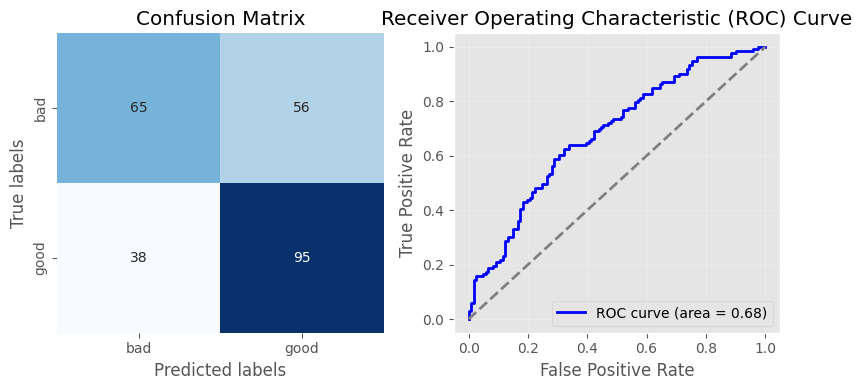

In [33]:
nb = run_model_and_evaluate(GaussianNB(), X_train, X_test, y_train, y_test)

Running Time: 0.02 seconds
Accuracy: 0.6929133858267716
ROC AUC: 0.6918536009445101
              precision    recall  f1-score   support

         bad       0.68      0.67      0.68       121
        good       0.70      0.71      0.71       133

    accuracy                           0.69       254
   macro avg       0.69      0.69      0.69       254
weighted avg       0.69      0.69      0.69       254



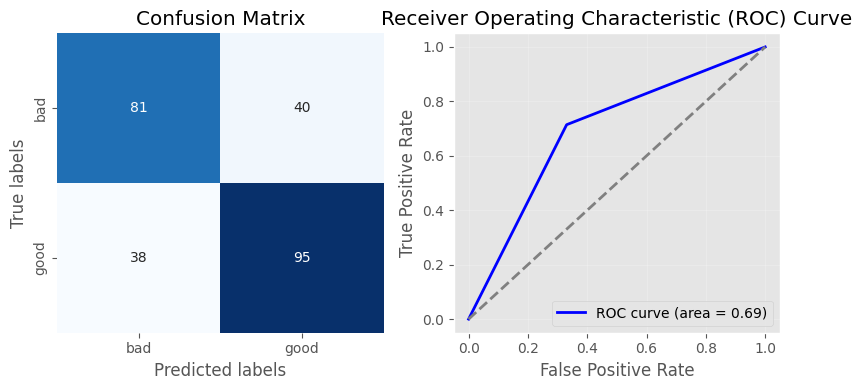

In [34]:
dt = run_model_and_evaluate(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

Running Time: 0.28 seconds
Accuracy: 0.84251968503937
ROC AUC: 0.8791399987572237
              precision    recall  f1-score   support

         bad       0.83      0.83      0.83       121
        good       0.85      0.85      0.85       133

    accuracy                           0.84       254
   macro avg       0.84      0.84      0.84       254
weighted avg       0.84      0.84      0.84       254



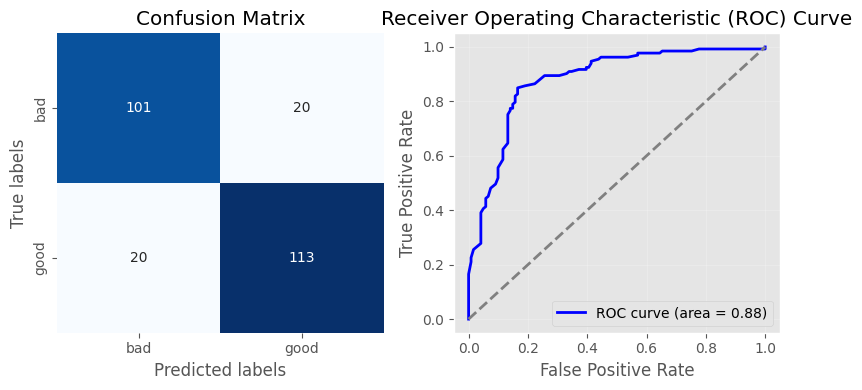

In [35]:
rf = run_model_and_evaluate(RandomForestClassifier(), X_train, X_test, y_train, y_test)

Running Time: 0.19 seconds
Accuracy: 0.7283464566929134
ROC AUC: 0.7966196482942894
              precision    recall  f1-score   support

         bad       0.71      0.73      0.72       121
        good       0.75      0.73      0.74       133

    accuracy                           0.73       254
   macro avg       0.73      0.73      0.73       254
weighted avg       0.73      0.73      0.73       254



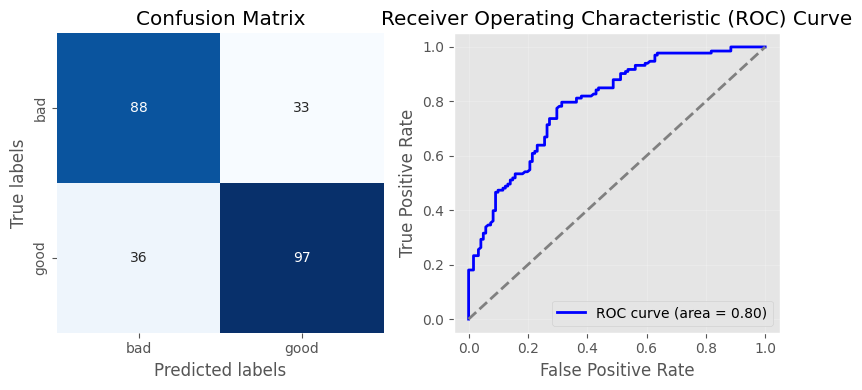

In [36]:
ada = run_model_and_evaluate(AdaBoostClassifier(), X_train, X_test, y_train, y_test)

Running Time: 0.24 seconds
Accuracy: 0.7559055118110236
ROC AUC: 0.8460200086994345
              precision    recall  f1-score   support

         bad       0.75      0.73      0.74       121
        good       0.76      0.78      0.77       133

    accuracy                           0.76       254
   macro avg       0.76      0.75      0.75       254
weighted avg       0.76      0.76      0.76       254



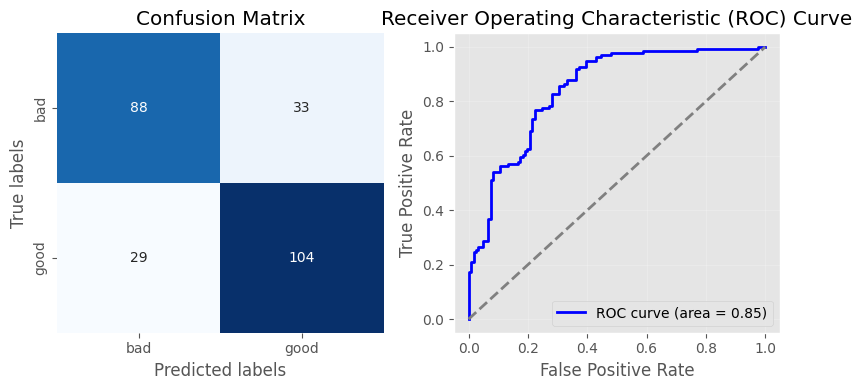

In [37]:
gdb = run_model_and_evaluate(GradientBoostingClassifier(), X_train, X_test, y_train, y_test)

Running Time: 2.16 seconds
Accuracy: 0.8031496062992126
ROC AUC: 0.8691356490399552
              precision    recall  f1-score   support

         bad       0.81      0.77      0.79       121
        good       0.80      0.83      0.82       133

    accuracy                           0.80       254
   macro avg       0.80      0.80      0.80       254
weighted avg       0.80      0.80      0.80       254



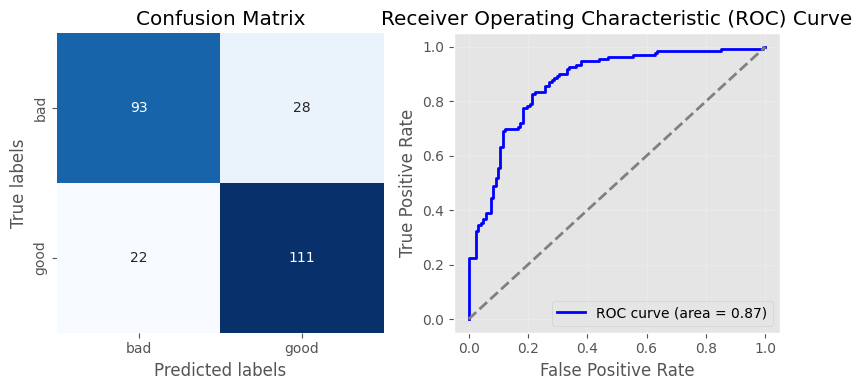

In [38]:
cat = run_model_and_evaluate(CatBoostClassifier(verbose=0), X_train, X_test, y_train, y_test)